In [21]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

plt.style.use('ggplot')

In [22]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): 
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True 
        ).values 
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    mean = np.mean(pd_boot_data)
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    ) 
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"ci": ci, "p_value": p_value, 'mean': mean}

In [23]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv', sep = ';', index_col=0, decimal = ',')
df.head()

value experimentVariant
1  10.380495           Control
2   9.546867           Control
3  11.088215           Control
4  10.147274           Control
5   9.789808           Control

In [24]:
df.isna().sum()

value                0
experimentVariant    0
dtype: int64

In [25]:
df.shape

(1000, 2)

In [26]:
df.dtypes

value                float64
experimentVariant     object
dtype: object

In [30]:
#Подготовка данных: разделим данные о контрольной и эксперементальной группе на два разных датафрейма
#Для использования bootstrap переведем данные колонки value в формат float

control = df[df.experimentVariant == 'Control']
control.reset_index(drop=True, inplace = True)
control.shape

(500, 2)

In [31]:
#Подготовка данных: разделим данные о контрольной и эксперементальной группе на два разных датафрейма
#Для использования bootstrap переведем данные колонки value в формат float

treatment = df[df.experimentVariant != 'Control']
treatment.reset_index(drop=True, inplace = True)
treatment.shape

(500, 2)

# Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value

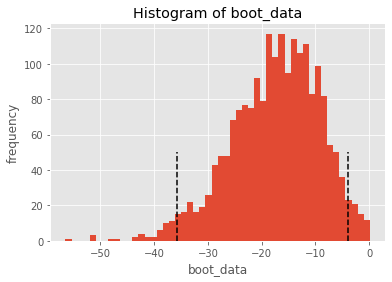

{'ci':                0
 0.025 -35.698112
 0.975  -3.898672,
 'p_value': 0.034059299556393995,
 'mean': 0   -17.432051
 dtype: float64}

In [32]:
#Значение pvalue меньше 0.05, значит между средним значением контрольной и эксперементальной группой есть статистически значимые отличия

get_bootstrap(control.value, treatment.value, boot_it = 2000, statistic = np.mean)

In [34]:
#Значение pvalue больше 0.05, значит между контрольной и эксперементальной группой нет статистически значимых отличий

mannwhitneyu(control.value, treatment.value)

MannwhitneyuResult(statistic=124189.5, pvalue=0.42960742912427896)

In [35]:
#Результаты bootstrap свидетельствуют о том, что между средним значением эксперементальной и контрольной группы есть статистически значимые отличия.
#В то время как критерий Манна-Уитни говорит об обратном
#Возможно результаты среднего значения в bootstrap были сискажены выбросами в одной из групп


In [36]:
#разница между контрольной и эксперементальной группой
difference = (control.value - treatment.value)

In [37]:
#распределение разницы между значениями двух групп
#в целом большинство этих значений близки к нулю 
#однако есть 5 заметных выбросов, которые и искажают среднее значение при использовании bootstrap
difference.sort_values().head(10)

499   -2988.500434
498   -1988.830922
497   -1491.219910
496   -1189.738926
495    -989.026071
339       0.000000
338       0.000000
337       0.000000
336       0.000000
335       0.000000
Name: value, dtype: float64

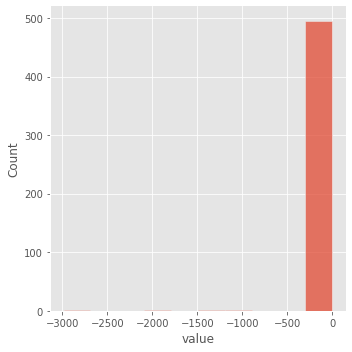

In [38]:
#Визуализируем распредение значений разницы между двумя группами

sns.displot(difference)

In [39]:
#Посмотрим как сильно среднее значение смещается влево из-за выбросов
#Для это посмотрим отличия между медианой и среднем значением
#Из-за нескольких выбрасов среднее значение сильно смещается влево

f'Значение медианы равно {difference.median()} и значение среднего равно {difference.mean()}'

'Значение медианы равно 0.0 и значение среднего равно -17.29463252285728'

In [40]:
#Можно предположить, что результаты bootstrap и критерия Манна-Уитни оказались противоположные друг другу
#Из-за искаженного среднего значения разницы между двумя группами
#Что было вызвано 5 выбросами в эксперементальной группе (treatment)

#Чтобы убедиться в том, что между группами есть или нет статистически значимых отличий 
#Следует выбрать показатель, который будет устойчивым к выбросам 
#Медиана отлично подойдет для этого

# Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value

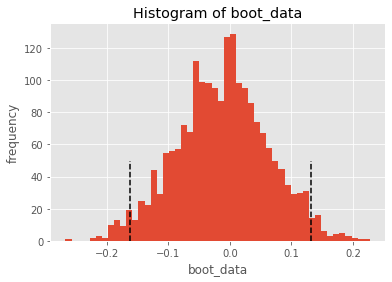

{'ci':               0
 0.025 -0.162673
 0.975  0.132163,
 'p_value': 0.8716250425730055,
 'mean': 0   -0.012005
 dtype: float64}

In [41]:
#Значение pvalue больше 0.05, значит между медианой контрольной и эксперементальной группой нет статистически значимых отличий


get_bootstrap(control.value, treatment.value, boot_it = 2000, statistic = np.median)

In [42]:
#Значение pvalue больше 0.05, значит между контрольной и эксперементальной группой нет статистически значимых отличий

mannwhitneyu(control.value, treatment.value)

MannwhitneyuResult(statistic=124189.5, pvalue=0.42960742912427896)

In [43]:
#В этот раз и bootstrap, и критерий Манна-Уитни показали высокий показатель pvalue (больше 0.05)
#Это говорит о том, что между двумя группами нет статистически значимых отличий 

# Вывод

1) При сравнении средних значений контрольной и эксперементальной группы с помощью bootstrap мы получили статистически значимые отличия этого показателя в двух группах. В тоже время критерий Манна-Уитни показал, что между группами статистически значимых отличий нет. Дальнейший анализ расхождений между bootstrap и критерием Манна-Уитни показал, что такие результаты были получены из-за 5 выбросов в эксперементальной группе (treatment), которые исказили среднее значение разницы между двумя группами в bootstrap. Это и привело к тому что мы получили статистически значимые отличия средних значений в двух группах.

2) При сравнении медиан контрольной и эксперементальной группы с помощью bootstrap мы не получили статистически значимых отличий этого показателя в двух группах. Критерий Манна-Уитни также показал, что между группами статистически значимых отличий нет. Медиана устойчива к выбросам, поэтому экстремально большие значения в эксперементальной группе (treatment) не повлияли на этот показатель.

3) С большей вероятностью можно сказать, что между контрольной и эксперементальной группой нет кардинальных отличий. Однако следует разобраться в причинах появления экстремально больших выбросов (5 значений) в эксперементальной группе, чтобы понять были ли эти выбросы получены в результате ошибки или же они отражают какую-то закономерность в данных, которая имеет место быть в генеральной совокупности.